# Visão dos dados e desafios

## Dicionário das colunas e dos dados:

Dados históricos da Ibovespa (BVSP), retidados do site [https://br.investing.com](https://br.investing.com/indices/bovespa-historical-data), considerando dados diários de cotações em um período entre **27/12/2000 à 22/08/2023**.
> *Data da Consulta: 22/08/2023*


*  **Data**: A data em que a negociação ocorreu.
*  **Abertura**: O preço pelo qual um ativo começou a ser negociado no dia em questão.
*  **Mínimo**: O menor preço atingido pelo ativo durante o dia de negociação.
*  **Máximo**: O preço mais alto atingido pelo ativo durante o dia de negociação.
*  **Volume** (Vol.): A quantidade total de ações (ou contratos) negociados durante o dia. Indica o interesse e a atividade dos investidores.
*  **Variação** (Var%): A diferença entre o preço de fechamento do dia atual e o preço de fechamento do dia anterior, geralmente expressa em porcentagem. Ela mostra a mudança no valor do ativo de um dia para o outro.



## Objetivos:

> Criar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

> Acurácia do modelo acima de 70%

# Início do projeto

## Importação de biblioyecas e criação de funções gerais necessárias

In [3]:
# instalação de bilbiotecas necessárias
!pip install prophet pandas_ta statsforecast pyramid

In [4]:
# importanto as bibliotecas
import numpy as np
from numpy import mean
import math
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from scipy import stats
from datetime import date, time, datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation # validação de métricas
from prophet.diagnostics import performance_metrics # validação de métricas

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


**Função para cálculo da mérica WMAPE**

In [5]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

## Importação da base e primeiras análises dos dados

In [6]:
from google.colab import drive # importar módulo do drive e upar base de dados pelo diretório
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [7]:
ibovespa_diario = pd.read_csv("drive/My Drive/Pos Tech Base de Dados/Tech Challenge Fase 2/Base de Dados/dados_ibovespa_dez00-ago23.csv", sep=",", parse_dates=[0], index_col="Data",dayfirst=True) # definição da coluna Data como index
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,"3,67M","-0,76%"
2019-12-27,116.534,117.205,117.803,115.995,"3,91M","-0,57%"
2019-12-26,117.203,115.864,117.220,115.673,"3,79M","1,16%"
2019-12-23,115.863,115.119,115.863,114.964,"4,00M","0,64%"
2019-12-20,115.121,115.133,115.171,114.526,"6,89M","-0,01%"


In [8]:
print("Range de datas:")
print(f"\tData inicial:",ibovespa_diario.index.min())
print(f"\tData final:",ibovespa_diario.index.max())

Range de datas:
	Data inicial: 2000-12-27 00:00:00
	Data final: 2023-08-22 00:00:00


In [9]:
total = ibovespa_diario.shape[0]
print("Total de dados na base: ", total)

Total de dados na base:  5611


In [10]:
ibovespa_diario.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5611 entries, 2019-12-30 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    5611 non-null   float64
 1   Abertura  5611 non-null   float64
 2   Máxima    5611 non-null   float64
 3   Mínima    5611 non-null   float64
 4   Vol.      5610 non-null   object 
 5   Var%      5611 non-null   object 
dtypes: float64(4), object(2)
memory usage: 306.9+ KB


Necessário realizar alguns pré-processamentos nos dados:
<!-- * Colunas "Último","Abertura", "Máxima", "Mínima": Ajustar casa decimal (valor em milhar) e alterar o type para int. -->

* Vol: retirar caracteres "K" e "M" e tratar valores

* Var%: Retirar caracter "%".

## Tratamento e pré-processamento de dados da base

In [11]:
# cols_int = ["Último","Abertura", "Máxima", "Mínima"]

# for column in cols_int:
#     ibovespa_diario[column] = (ibovespa_diario[column] * 1000).astype(int)
#     # ibovespa_diario[column] = ibovespa_diario[column].astype(int)

# ibovespa_diario.head()

In [12]:
# função para retirar caracteres não numericos da coluna Volume
def convert_volume(vol):
    if isinstance(vol, str):
        if 'M' in vol:
            return float(vol.replace('M', '')) * 1000000
        elif 'K' in vol:
            return float(vol.replace('K', '')) * 1000
    return vol

ibovespa_diario = ibovespa_diario.replace(",",".", regex = True) # Tudo que é vírgula vira ponto
ibovespa_diario['Var%'] = ibovespa_diario['Var%'].replace("%"," ", regex = True).astype(float) # Tudo que é vírgula vira ponto
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].apply(convert_volume)
ibovespa_diario['Vol.'] = round(ibovespa_diario['Vol.'].astype(float))
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000.0,-0.76
2019-12-27,116.534,117.205,117.803,115.995,3910000.0,-0.57
2019-12-26,117.203,115.864,117.220,115.673,3790000.0,1.16
2019-12-23,115.863,115.119,115.863,114.964,4000000.0,0.64
2019-12-20,115.121,115.133,115.171,114.526,6890000.0,-0.01


In [13]:
ibovespa_diario.dtypes # validação dos tipos de dados

Último      float64
Abertura    float64
Máxima      float64
Mínima      float64
Vol.        float64
Var%        float64
dtype: object

> Tratamento das colunas realizada, com exceção da coluna Vol. que ainda está em float. Ao fazer a transformação, ocorreu um erro sinalizando que existe um dado nulo nesta coluna.

### Identificação de dados nulos ou duplicados

In [14]:
val_duplicated = ibovespa_diario.duplicated().sum()

print("Validação de dados duplicados:")
if val_duplicated > 0:
  print(f"\tExistem valores duplicados na base, é necessário investigar.")
else:
  print(f"\tNão esxistem valores duplicados na base!")

Validação de dados duplicados:
	Não esxistem valores duplicados na base!


In [15]:
percent_nulos = 100*((ibovespa_diario.isnull().sum())/(len(ibovespa_diario))) # avaliação de dados nulos
print(percent_nulos)

Último      0.000000
Abertura    0.000000
Máxima      0.000000
Mínima      0.000000
Vol.        0.017822
Var%        0.000000
dtype: float64


Existem valores nulos na coluna Vol.

In [16]:
ibovespa_diario.loc[ibovespa_diario['Vol.'].isnull()]

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40.377,40.592,40.592,39.96,NaN,-0.53


In [17]:
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].fillna(value = 0) # alterando o valor nulo por 0
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].astype(int) # transformação do tipo para inteiro
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000,-0.76
2019-12-27,116.534,117.205,117.803,115.995,3910000,-0.57
2019-12-26,117.203,115.864,117.220,115.673,3790000,1.16
2019-12-23,115.863,115.119,115.863,114.964,4000000,0.64
2019-12-20,115.121,115.133,115.171,114.526,6890000,-0.01


Por fim, criação de uma coluna com o dia da semana para avaliarmos distribuição

In [18]:
def obter_dia_da_semana(data_index):
    try:
        data = datetime.strptime(data_index, '%d/%m/%Y')
        dias_da_semana = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
        dia_da_semana = dias_da_semana[data.weekday()]
        return dia_da_semana
    except ValueError:
        return "Data inválida"

ibovespa_diario['Dia_da_Semana'] = ibovespa_diario.index.map(lambda x: obter_dia_da_semana(x.strftime('%d/%m/%Y')))
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Dia_da_Semana
Data,,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000,-0.76,Segunda-feira
2019-12-27,116.534,117.205,117.803,115.995,3910000,-0.57,Sexta-feira
2019-12-26,117.203,115.864,117.220,115.673,3790000,1.16,Quinta-feira
2019-12-23,115.863,115.119,115.863,114.964,4000000,0.64,Segunda-feira
2019-12-20,115.121,115.133,115.171,114.526,6890000,-0.01,Sexta-feira


## EDA e primeiras inferências

> Variáveis principais:
* ds = data
* y = Último - O preço de fechamento da bolsa no dia em questão

**Visão considerando toda série histórica (2000 a 2023)**

In [19]:
ibovespa_diario.describe().round(2)

,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,5611.00,5611.00,5611.00,5611.00,5.611000e+03,5611.00
mean,58.87,58.85,59.45,58.26,6.689736e+07,0.05
std,31.07,31.07,31.31,30.81,1.170886e+08,1.75
min,8.37,8.40,8.51,8.22,0.000000e+00,-14.78
25%,37.44,37.41,37.98,36.86,3.010000e+06,-0.88
50%,56.44,56.44,56.97,55.90,5.380000e+06,0.07
75%,74.46,74.42,75.14,73.79,9.910000e+07,1.03
max,130.78,130.78,131.19,129.53,9.949600e+08,14.66


**Inferências iniciais:**

* Média de preço de fechamento histórico em 58.87 e a mediana é de 56.44, aparentemente indicando que há poucos períodos com outliers.

* O desvio padrão é de 31.07, sendo um valor consideravelmente alto. Para os dados atuais, o desvio padrão pode indicar a **volatilidade do mercado**.
> Nosso desvio padrão médio representa 53% da média, indicando momentos de alta volatidade e fases de baixa.

* Apesar de não ser o target, podemos ver também uma dispersão alta entre valores mínimos e máximos, mostrando que houveram momentos significativos de queda e de alta ao longo dos 23 anos.

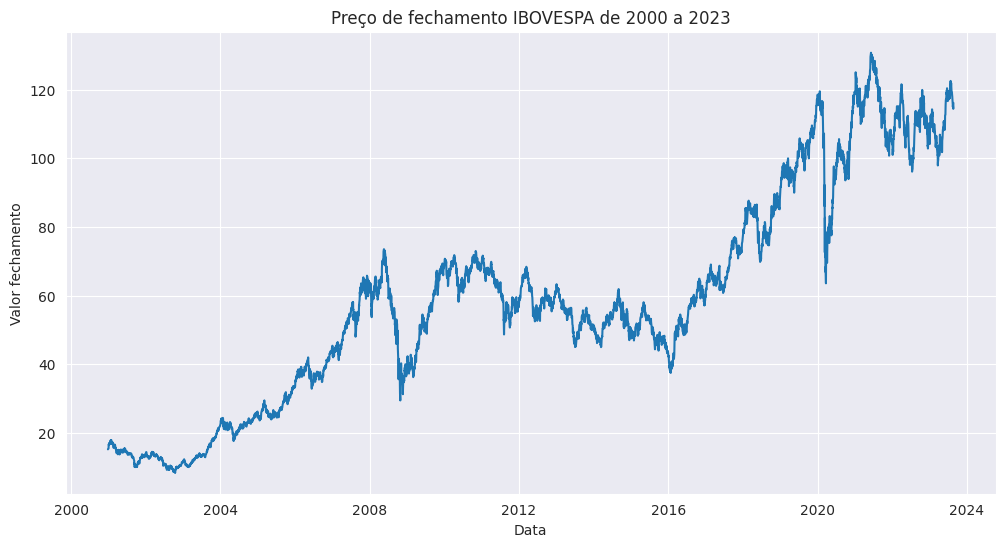

In [20]:
sns.set_style("darkgrid")
ibovespa_diario = ibovespa_diario.sort_index()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(ibovespa_diario.index, ibovespa_diario.Último)
plt.xlabel('Data')  # Adiciona rótulo ao eixo x
plt.ylabel('Valor fechamento')  # Adiciona rótulo ao eixo y
plt.title('Preço de fechamento IBOVESPA de 2000 a 2023')
plt.show()

**Inferências iniciais sobre a dispersão dos dados ao longo do tempo:**

* Aparentemente, o preço de fechamento da bolsa aumenta ao longo dos anos, com maior amplitude após o ano de 2016.

* No momento atual (Agosto/2023), há um comportamento de leve queda em relação aos períodos anteriores.

* Nas quedas em 2008 e 2020, é possível perceber como fatores externos impactam diretamente na reação do mercado (possíveis outliers)
> **2008:** Os resultados da economia brasileira foram bastante influenciados pela crise financeira internacional em 2009, considerada como a maior crise econômica da história.

    > **2020**: Impacto da pandemia global do Coronavírus.

* Percebemos que os dados sofrem diversas variações ao longo do tempo, mas sem uma sazonalidade muito evidente, consequência da sensibilidade do dado para fotores externos ou incertezas de mercado.


**Análise de dados por dia da semana**

Objetivo: Qual a distrbuiçção por dia e existe uma sazonalidade diária?

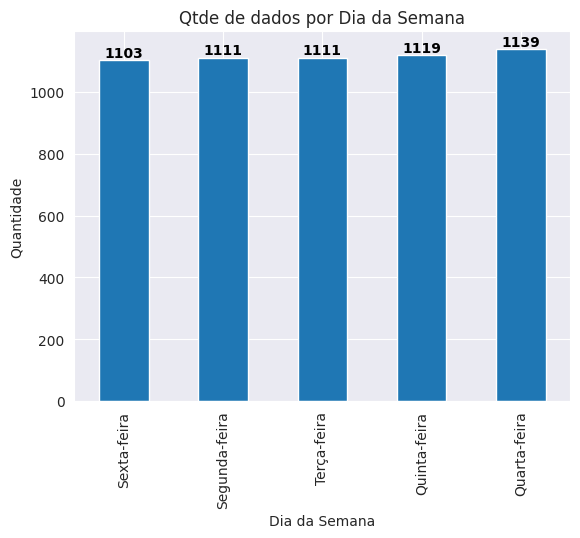

In [21]:
dados_dia = ibovespa_diario.groupby("Dia_da_Semana")["Último"].nunique()
dados_dia.sort_values(ascending=True, inplace=True)
# Criar o gráfico de barras
ax = dados_dia.plot(kind='bar')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade')
plt.title('Qtde de dados por Dia da Semana')

# Adicionar valores como anotações nas barras
for idx, value in enumerate(dados_dia):
    ax.text(idx, value + 10, str(value), ha='center', color='black', fontweight='bold')

plt.show()

* Há uma concentração linear em relação dias da semana, com quarta-feria sendo o dia com maiores obsevarções desde o começo.

* Aqui, percebemos que o dados captados pela IBOVESPA são relacionados a dias úteis, sem presença de final de semana ou até mesmo feriados.

* Além disso, no gráfico abaixo percebemos que média de pontos do fechamento se mantem ao longo dos dias, sem indicações de fechamentos maiores em algum dia específico.

In [22]:
ibovespa_diario.groupby("Dia_da_Semana")["Último"].describe().round(2).T # avaliação das estatísticas por dia da semana

Dia_da_Semana,Quarta-feira,Quinta-feira,Segunda-feira,Sexta-feira,Terça-feira
count,1142.00,1122.00,1119.00,1110.00,1118.00
mean,58.92,59.01,58.80,58.78,58.84
std,31.03,31.18,31.13,31.09,30.98
min,8.37,8.87,8.45,8.72,8.51
25%,37.70,37.50,37.24,37.34,37.41
50%,56.46,56.79,56.49,56.49,56.24
75%,74.78,74.68,74.32,73.80,74.32
max,129.91,130.08,130.78,130.13,130.09


**Histograma e distribuição dos dados**

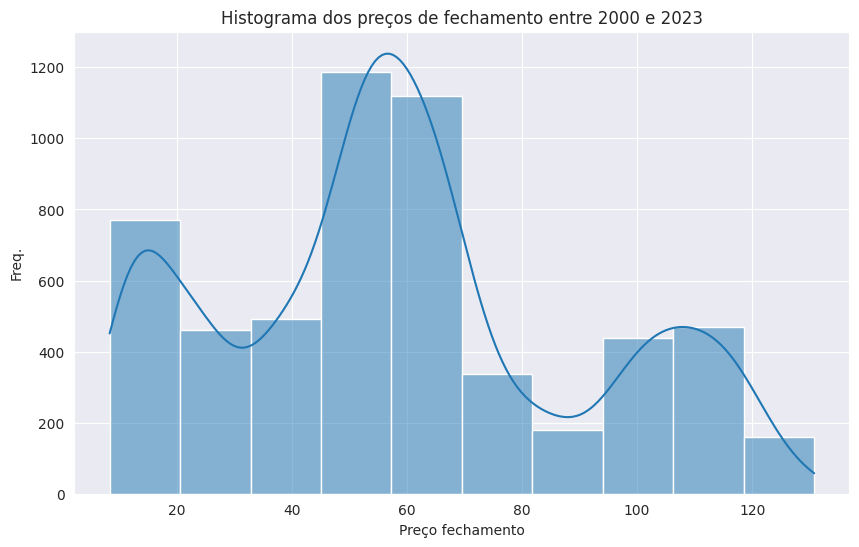

In [23]:
plt.figure(figsize=(10,6))
plot = ibovespa_diario.Último
sns.histplot(plot, bins=10, kde=True)
plt.xlabel('Preço fechamento')
plt.ylabel('Freq.')
plt.title('Histograma dos preços de fechamento entre 2000 e 2023')
plt.show()

A distribuição dos dados indica uma distribuição assimétrica á esquerda, indicando que há uma concentração maior de dados de fechamento até 60.

Pelo gráfico, entendemos que essa concentração de dados ocorre antes do ano de 2016, quando houve o maior crescimento.

<ipython-input-24-540053158e8e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = ibovespa_diario.corr().round(2)


<Axes: >

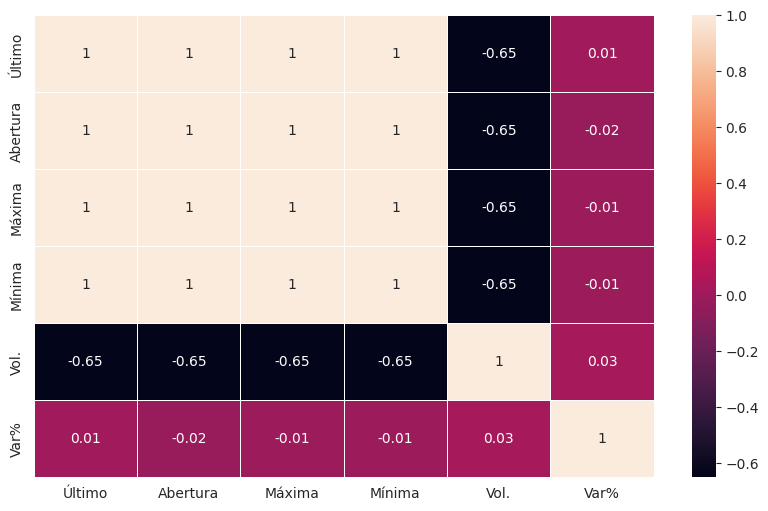

In [24]:
correlation_matrix = ibovespa_diario.corr().round(2)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

* Há uma correlação negativa moderada entre o volume de transações realizadas (Vol.) e os preços registrados no dia.

## EDA a partir de 2016

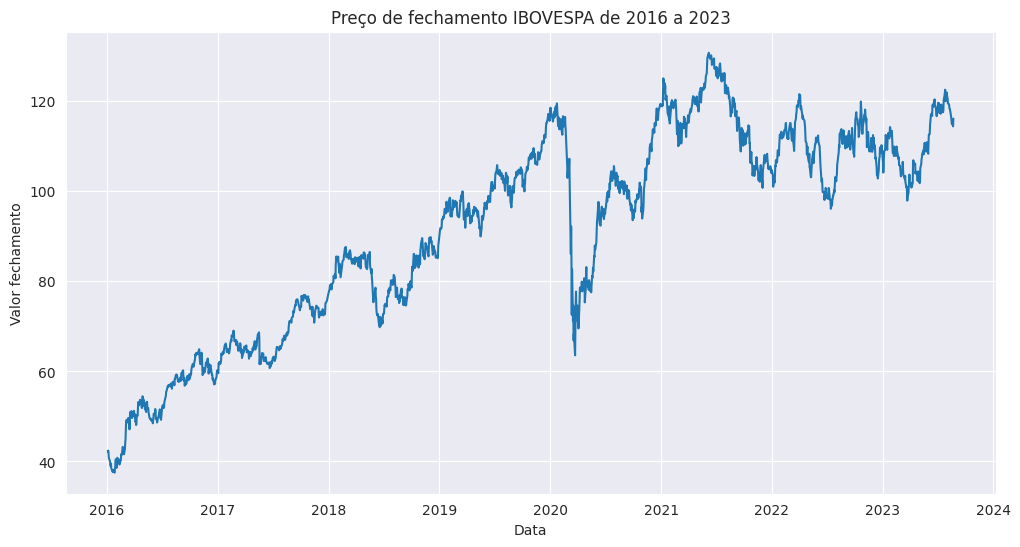

In [25]:
dados_2016 = ibovespa_diario.loc[ibovespa_diario.index.year > 2015]
dados_2016 = dados_2016.sort_index()
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(dados_2016.index, dados_2016.Último)
plt.xlabel('Data')  # Adiciona rótulo ao eixo x
plt.ylabel('Valor fechamento')  # Adiciona rótulo ao eixo y
plt.title('Preço de fechamento IBOVESPA de 2016 a 2023')
plt.show()

**Inferências:**

* Ao direcionar as análises a partir de 2016, fica mais evidente algumas das movimentações de mercado, desde seu crescimento até a queda entre 2020-2021 (COVID)

* Ainda assim, não é possível identificar padrões de sazonalidade, apesar da tendência de crescimento.

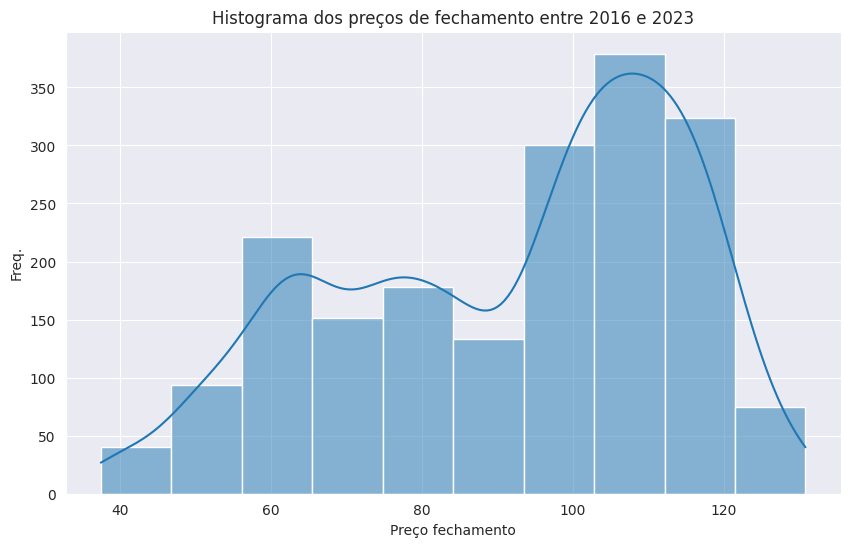

In [26]:
plt.figure(figsize=(10,6))
plot = dados_2016.Último
sns.histplot(plot, bins=10, kde=True)
plt.xlabel('Preço fechamento')
plt.ylabel('Freq.')
plt.title('Histograma dos preços de fechamento entre 2016 e 2023')
plt.show()

In [27]:
dados_2016 = ibovespa_diario.loc[ibovespa_diario.index.year > 2015]
dados_anteriores = ibovespa_diario.loc[ibovespa_diario.index.year <= 2015]

mean1, mean2 = dados_2016.Último.mean(), dados_anteriores.Último.mean() # calcula as médias
var1, var2 = dados_2016.Último.var(), dados_anteriores.Último.var() # calcula a variância entre as partes

# prints
print('media pós-2016 = %f, \nmedia antes 2016 = %f' % (mean1, mean2))
print('variancia pós-2016 = %f, \nvariancia antes 2016 = %f' % (var1, var2))

media pós-2016 = 91.638560, 
media antes 2016 = 42.159126
variancia pós-2016 = 510.003325, 
variancia antes 2016 = 370.676175


A partir do histograma acima e dos comparativos entre médias e variãncias dos dados antes e pós-2016, vemos que o comportamento mudou com um maior distribuição de dados de fechamento acima de 100, correspondendo ao cenário atual.

In [28]:
dados_2016.describe()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,1895.000000,1895.000000,1895.000000,1895.000000,1.895000e+03,1895.000000
mean,91.638560,91.601120,92.488383,90.740204,7.461678e+06,0.065061
std,22.583253,22.603284,22.717732,22.443089,4.263923e+06,1.606065
min,37.497000,37.501000,38.031000,37.046000,0.000000e+00,-14.780000
25%,73.732500,73.619000,74.516500,72.621000,3.810000e+06,-0.730000
50%,97.886000,97.879000,98.439000,96.997000,5.900000e+06,0.090000
75%,110.246500,110.239000,111.397000,109.219500,1.082000e+07,0.935000
max,130.776000,130.776000,131.190000,129.526000,2.603000e+07,13.910000


* Além da média e variância, vemos uma queda no desvio padrão de 31.07 para 22.58.
* Vemos também uma redução na dispersão entre os valores mínimos e máximos de fechamento.
> **Essas estatísticas indicam uma certa estabilidade da economia brasileira a partir de 2016**.




* Por esse motivo, inicialmente decidimos seguir as análises e modelo com dados a partir deste recorte de 2016.

## Análises temporais - Visão e análises

> O **preço de fechamento** reflete o valor final pelo qual o ativo foi negociado durante o dia e é frequentemente usado como um indicador-chave para análise de séries temporais.

* ds = ibovespa_diario.index
* y = ibovespa_diario["Último]
* ticker = ibovespa

### Análise do Seasonal Decompose - Dados pós-2016

Objetivo: Análise dos componentes da nossa série temporal, para entender sua estrutura e complexidade.

In [29]:
# configuralção da decomposição
dados_decompose = dados_2016[['Último']]
dados_decompose = dados_decompose.dropna() # eliminar dados nulos
dados_decompose = dados_decompose.sort_index() # eliminar ordenar as datas em forma crescente

resultados = seasonal_decompose(dados_decompose, period=5) # O parâmetro “período” é o número de observações em um ciclo sazonal. Por exemplo, se você tiver observações diárias e sazonalidade semanal, o período será 7.

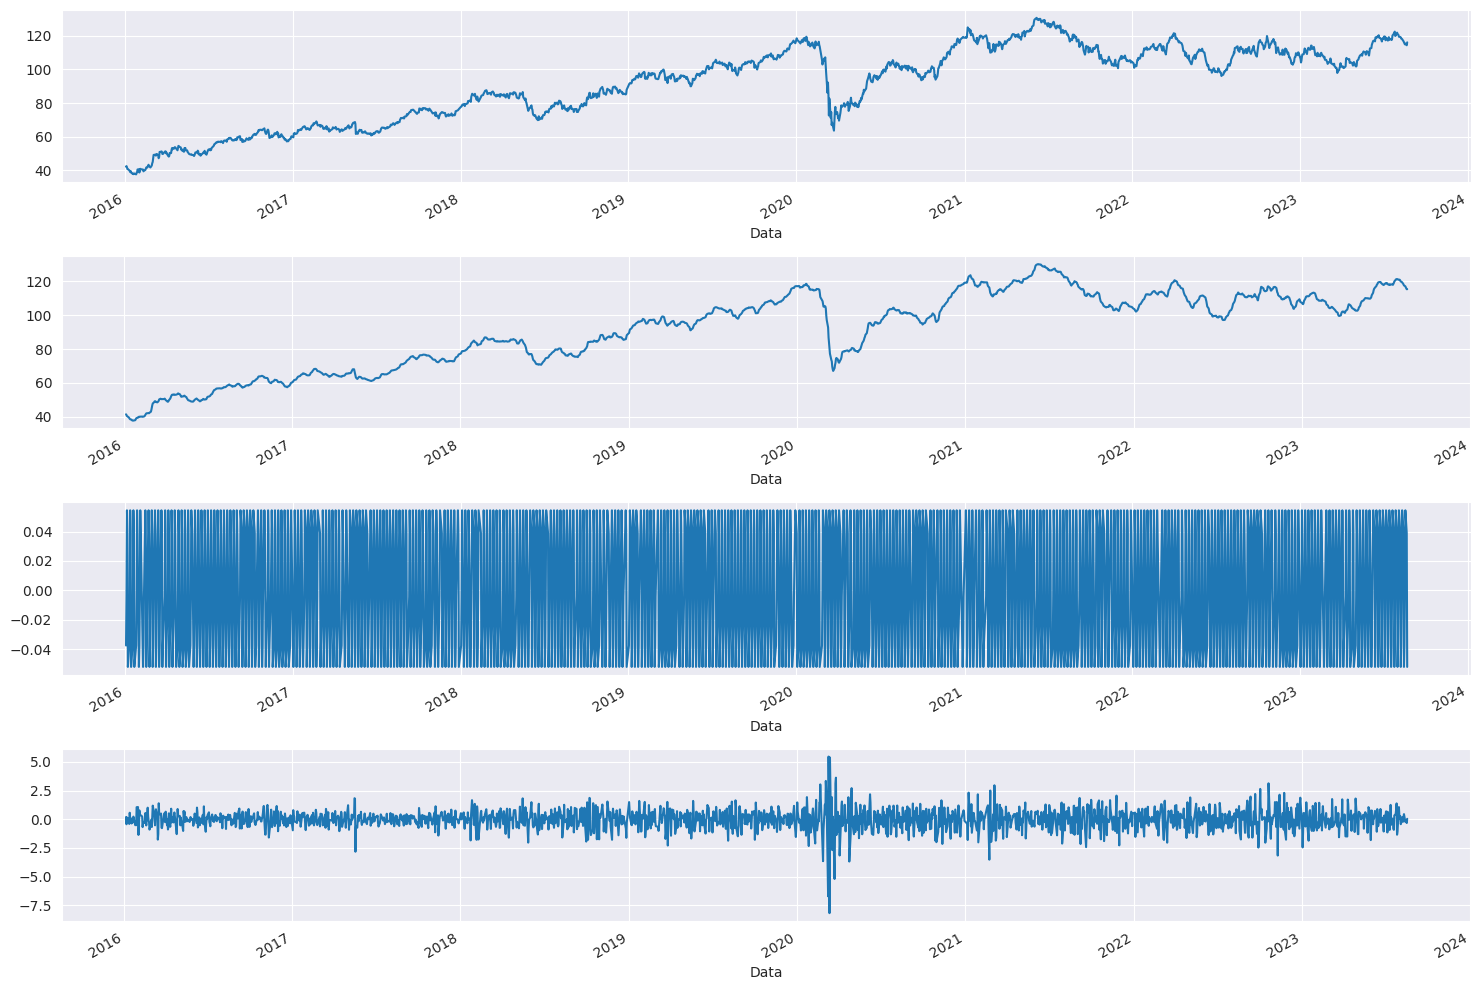

In [30]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,10))

resultados.observed.plot(ax=ax1) # observação dos gráficos ao longo do tempo
resultados.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultados.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultados.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

> **Inferências iniciais dos gráficos**:

* Pelas análises de obsevração e tendência, temos um comportamento de crescimento ao longo dos anos, indicando que há um aumento no volume das cotações em relação à cotação no momento do fechamento.

* Vemos também que a concentração de resíduo fica maior no final do período analisado


* Analisando os dados de sazonalidade desde 2010, não é possível avaliar se há uma sazonalidade no comportamento dos dados. Vamos reduzir o tempo para ter uma avaliação melhor da situação.

Relembrando a distribuição dos dados

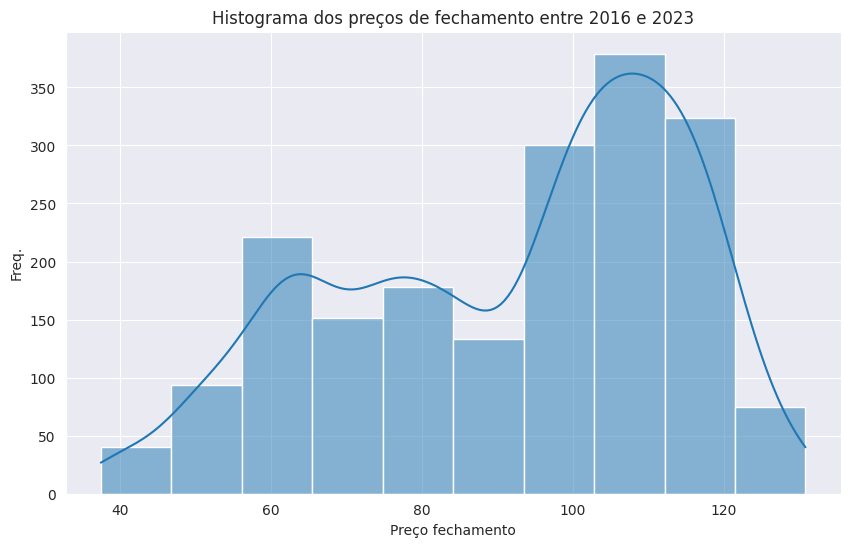

In [31]:
plt.figure(figsize=(10,6))
plot = dados_2016.Último
sns.histplot(plot, bins=10, kde=True)
plt.xlabel('Preço fechamento')
plt.ylabel('Freq.')
plt.title('Histograma dos preços de fechamento entre 2016 e 2023')
plt.show()

* A distribuição não é normal, com uma cauda a esquerda
* Pode indicar a necessidade de transformação nos dados, como diferenciação e log.

### Análise de Correlação

Objetivo: Determinar os coeficientes dos modelos de série temporal, além de ajudar a identificar sazonalide e tendência

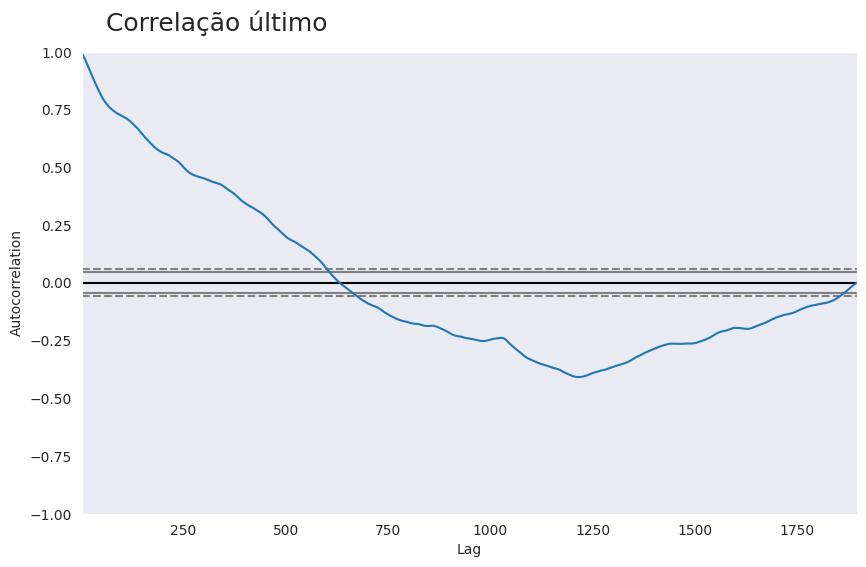

In [32]:
from pandas.plotting import autocorrelation_plot
ax = plt.figure(figsize=(10,6))
ax.suptitle('Correlação último', fontsize=18, x=0.26, y=0.95)
autocorrelation_plot(dados_decompose.Último)
ax = ax

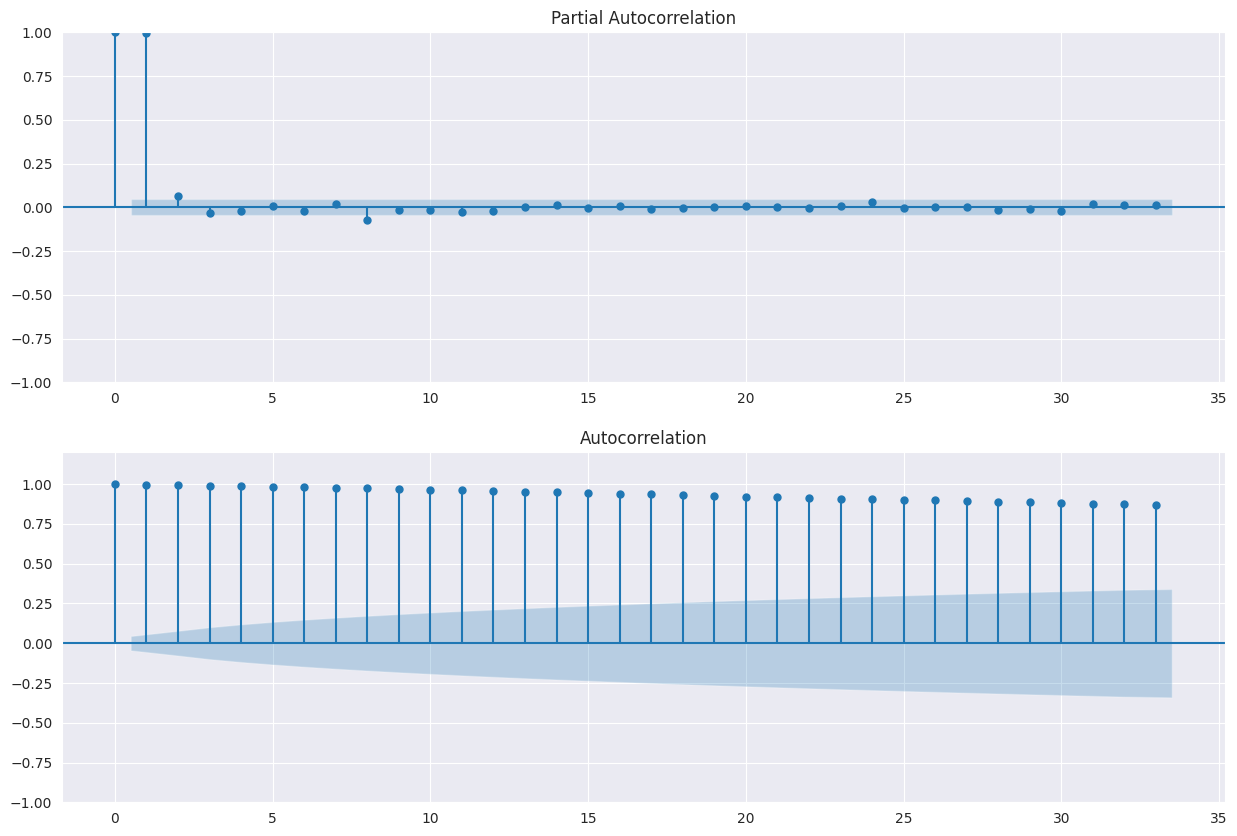

In [33]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,10))
plot_pacf(dados_decompose.Último, ax=ax1)
plot_acf(dados_decompose.Último, ax=ax2)
plt.ylim(-1,1.2)
# plt.tight_layout()
plt.show()

PACF: Autocorrelação parcial em 1, 2, 3 e 8

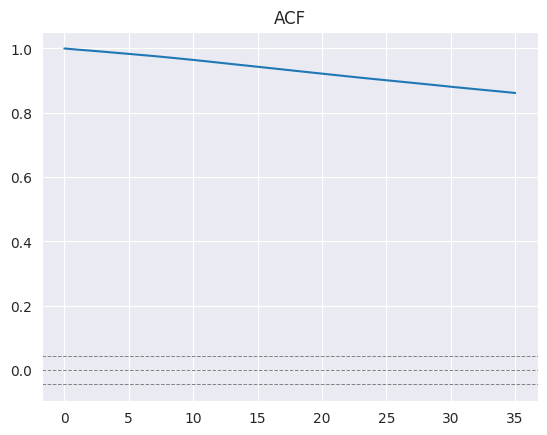

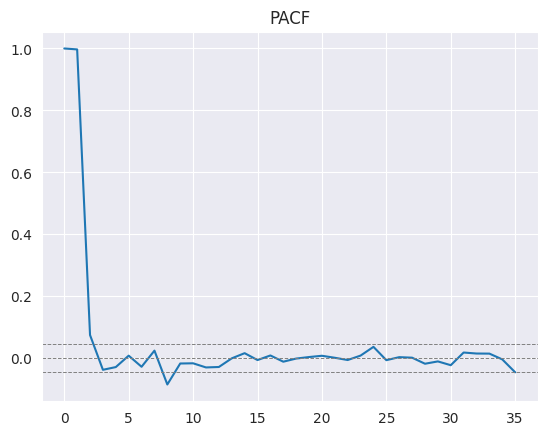

In [34]:
lag_acf = acf(dados_decompose.dropna(), nlags=35)
plt.plot(lag_acf)
plt.axhline(y=-1.96/(np.sqrt((len(dados_decompose)-1))), linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y=0/(np.sqrt((len(dados_decompose)-1))), linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y=1.96/(np.sqrt((len(dados_decompose)-1))), linestyle="--", color="gray", linewidth=0.7)
plt.title("ACF")
plt.show()

lag_pacf = pacf(dados_decompose.dropna(), nlags=35)
plt.plot(lag_pacf)
plt.axhline(y=-1.96/(np.sqrt((len(dados_decompose)-1))), linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y=0/(np.sqrt((len(dados_decompose)-1))), linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y=1.96/(np.sqrt((len(dados_decompose)-1))), linestyle="--", color="gray", linewidth=0.7)
plt.title("PACF")
plt.show()

### Análise do Teste AdFuller para chechar estacionaridade da base de dados

    H0 -> Série não estacionária (p-value > 0.05)
    H1 -> Série estacionária (p-value <= 0.05)

* **p-value > 0.05**: Falha para rejeitar a hipotese nula (h0) a série é não estacionária.

* **p-value ≤ 0.05**: Rejeita a hipotese nula (H0), a série é estacionária.

#### AdFuller considerando base pós 2010 - NÃO ESTACIONÁRIA (p-value = 0.77)

In [35]:
x = dados_2016.Último.values  # transformação dos dados em variável
results = adfuller(x)# configuração do teste
alpha = 0.05 # definição da significancia

# print das métricas do teste
print("Teste ADF - Dados pós 2011")
print(f"\tTeste Estatístico: {results[0]}")
print(f"\tP-Value: {results[1]}")
print("\tValores críticos:")

for key, value in results[4].items():
  print(f"\t\t{key}: {value}")

# avaliação final
print("\n\nAvaliação do p-value:")
if results[1] >= alpha:
  print(f"\tEstatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária")
else:
  print(f"\tRejeitar a hipótese nula - Série Estacionária.")


Teste ADF - Dados pós 2011
	Teste Estatístico: -2.213009274557135
	P-Value: 0.20155776740245196
	Valores críticos:
		1%: -3.433822016251123
		5%: -2.8630736989499335
		10%: -2.567586484303047


Avaliação do p-value:
	Estatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária


## Insights e descobertas da série temporal:

* Na decomposição da série, vemos que há comportamento de crescimento ao longo dos anos, indicando que há um aumento no volume das cotações em relação à cotação no momento do fechamento.

* Não foi possível visualizar facilmente uma sazonalide nos dados, ainda que haja o crescimento.

* Na autocorrelação **XYZ - ATUALIZAR**

* A distribuição dos dados de fechamento não segue a curva normal, com uma cauda a esquerda

* Pelo teste AdFuller podemos comprovar que a série de dados após 2016 pode ser classificada como **Não Estacionária**

# Criação dos modelos

**Especificando o Baseline (método mais simples)**: Usado como referência para avaliar outros métodos mais complexos
> Baseline: O valor de fechamento será baseado no valor anterior - dia anterior

**Preparação do dataset e separação de bases entre treino e validação**

In [36]:
# Criação do dataset
dados_modelo = dados_2016[["Último"]]
dados_modelo["unique_id"] = "ibovespa"
dados_modelo.reset_index(inplace=True)
dados_modelo = dados_modelo.rename(columns={"Data": "ds", "Último": "y"})
dados_modelo.dropna(inplace=True)

# informações gerais da base
print("Data inicial da base:", dados_modelo.index.min())
print("Data final da base:", dados_modelo.index.max())
print("Tamanho de dados na base:",len(dados_modelo))

Data inicial da base: 0
Data final da base: 1894
Tamanho de dados na base: 1895


<ipython-input-36-efcbae75c5e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_modelo["unique_id"] = "ibovespa"


In [37]:
periodo_base = int(len(dados_modelo) * 0.2) # determinando o período
train, test = dados_modelo.iloc[:-periodo_base], dados_modelo.iloc[-periodo_base:]
h = len(test)

## Print dos dados
print("Dados base treino:")
print("Data inicial:", train.index.min())
print("Data final:",train.index.max())
print("Tamanho de dados na base:",len(train))

print("\nDados base validação:")
print("Data inicial:", test.index.min())
print("Data final:",test.index.max())
print("Tamanho de dados na base:",len(test))

Dados base treino:
Data inicial: 0
Data final: 1515
Tamanho de dados na base: 1516

Dados base validação:
Data inicial: 1516
Data final: 1894
Tamanho de dados na base: 379


### Baseline com Naive
    WMape Naive: 5.40%
    MSE Naive: 5607.82%
    MAE Naive: 592.62%
    RMSE Naive: 748.85%

In [38]:
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(train)
forecast_naive = model.predict(h=h, level=[90])
forecast_naive = forecast_naive.reset_index().merge(test, on=['ds', 'unique_id'], how='left').dropna()

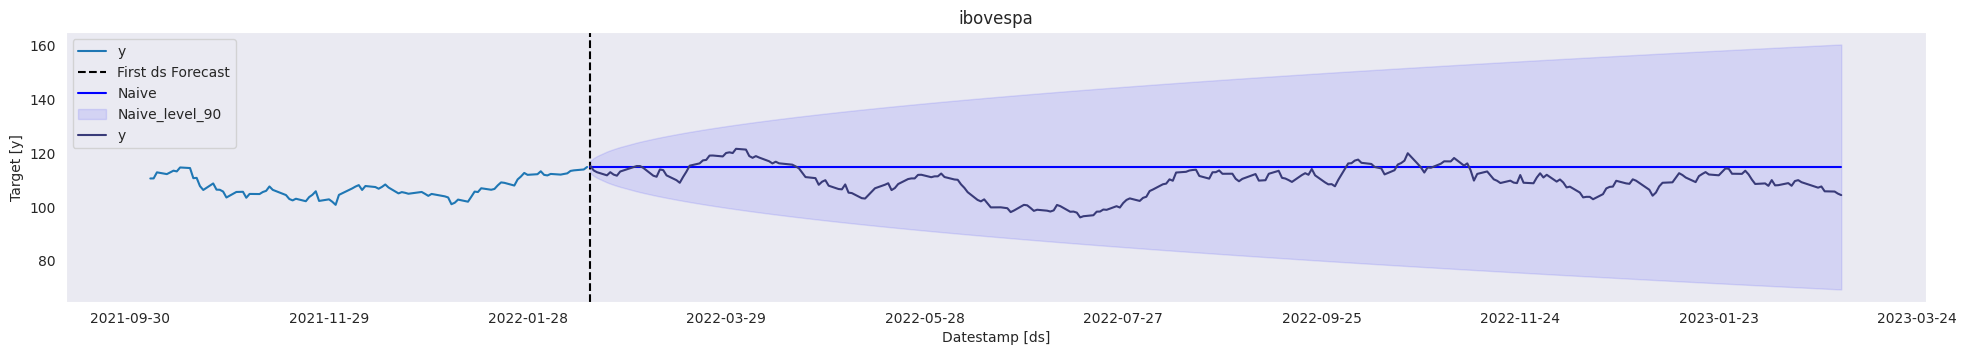

In [39]:
model.plot(train, forecast_naive, level=[90], unique_ids=["ibovespa"], max_insample_length=90)

In [40]:
# Avaliação de resultados Naive com Walk Foward
wmape_naive = wmape(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'WMape Naive: {wmape_naive:.2%}')

mse_naive = mean_squared_error(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'MSE Naive: {mse_naive:.2%}')

mae_naive = mean_absolute_error(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'MAE Naive: {mae_naive:.2%}')

rmse_naive = math.sqrt(mean_squared_error(forecast_naive['y'].values, forecast_naive['Naive'].values))
print(f'RMSE Naive: {rmse_naive:.2%}')

WMape Naive: 5.40%
MSE Naive: 5607.82%
MAE Naive: 592.62%
RMSE Naive: 748.85%


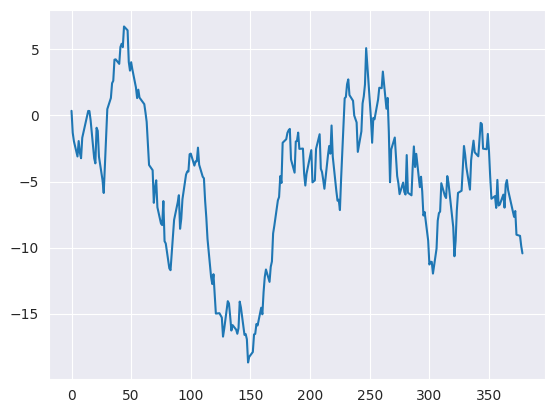

In [41]:
forecast_naive["residual"] = forecast_naive["y"] - forecast_naive["Naive"]
forecast_naive["residual"].plot()
plt.show()

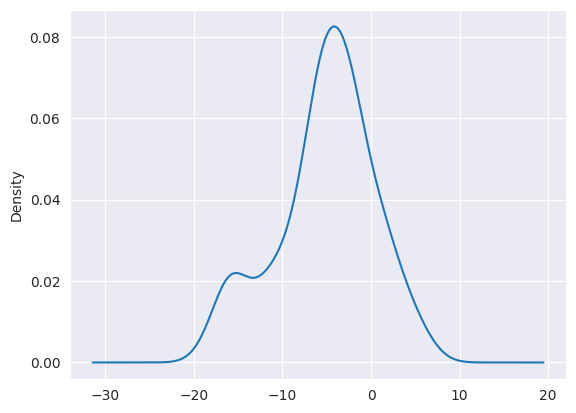

count    259.000000
mean      -5.122088
std        5.473395
min      -18.707003
25%       -7.778503
50%       -4.592003
75%       -1.719003
max        6.741997
Name: residual, dtype: float64


In [42]:
forecast_naive["residual"].plot(kind='kde')
plt.show()
print(forecast_naive["residual"].describe())

### SeasonalNaive: Baseline com sazonalidade (lags=8)

    WMape Season Naive: 4.49%
    MSE Season Naive: 4207.45%
    MAE Season Naive: 493.13%
    RMSE Season Naive: 648.65%

**Autocorrelação para definição dos lags**
      
lag = 8

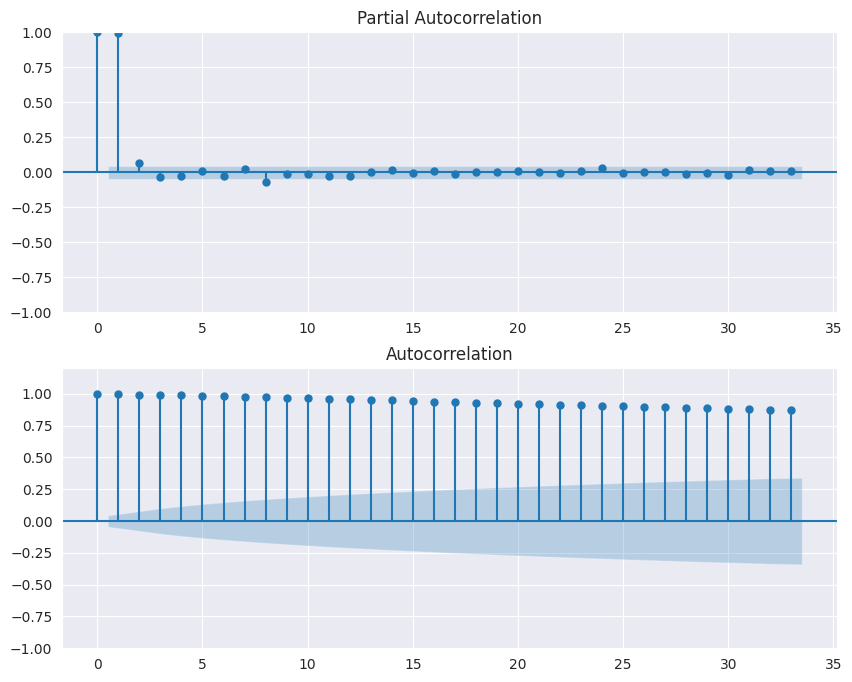

In [43]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))
plot_pacf(dados_decompose.Último, ax=ax1)
plot_acf(dados_decompose.Último, ax=ax2)
plt.ylim(-1,1.2)
plt.show()

In [44]:
periodo_base = int(len(dados_modelo) * 0.2) # determinando o período
train, test = dados_modelo.iloc[:-periodo_base], dados_modelo.iloc[-periodo_base:]
h = len(test)

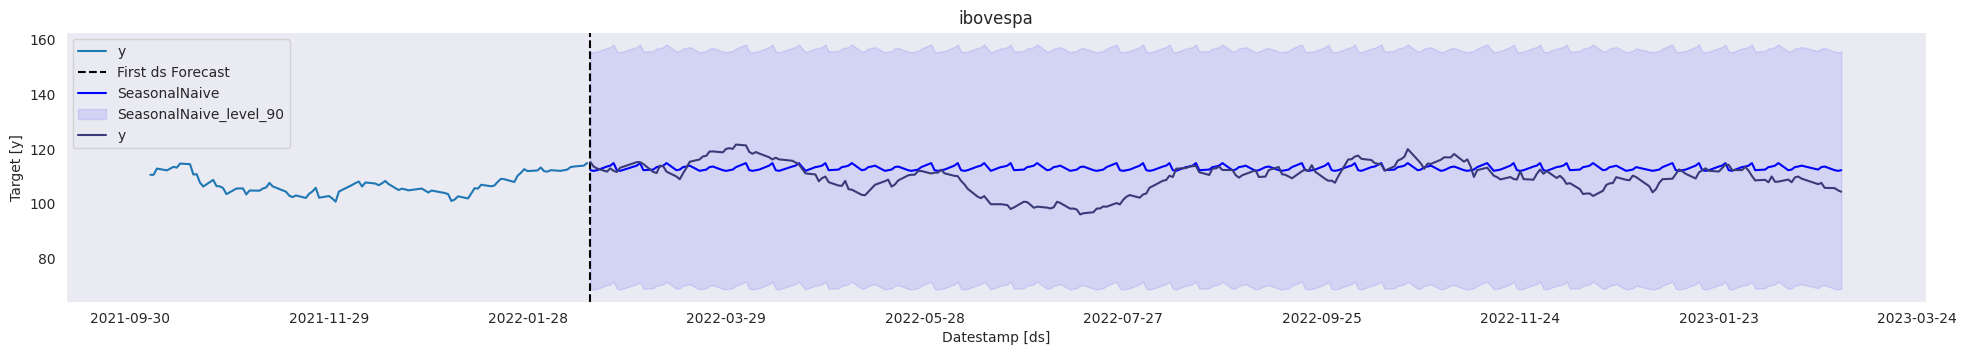

In [45]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=8)], freq='D', n_jobs=-1)
model_s.fit(train)

forecast_naives = model_s.predict(h=h, level=[90])
forecast_naives = forecast_naives.reset_index().merge(test, on=['ds', 'unique_id'], how='left').dropna()

model_s.plot(train, forecast_naives, level=[90], unique_ids=["ibovespa"], max_insample_length=90)

In [46]:
# Avaliação de resultados Naive com Walk Foward
wmape_naives = wmape(forecast_naives['y'].values, forecast_naives['SeasonalNaive'].values)
print(f'WMape Season Naive: {wmape_naives:.2%}')

mse_naives = mean_squared_error(forecast_naive['y'].values, forecast_naives['SeasonalNaive'].values)
print(f'MSE Season Naive: {mse_naives:.2%}')

mae_naives = mean_absolute_error(forecast_naives['y'].values, forecast_naives['SeasonalNaive'].values)
print(f'MAE Season Naive: {mae_naives:.2%}')

rmse_naives = math.sqrt(mean_squared_error(forecast_naives['y'].values, forecast_naives['SeasonalNaive'].values))
print(f'RMSE Season Naive: {rmse_naives:.2%}')

WMape Season Naive: 4.49%
MSE Season Naive: 4207.45%
MAE Season Naive: 493.13%
RMSE Season Naive: 648.65%


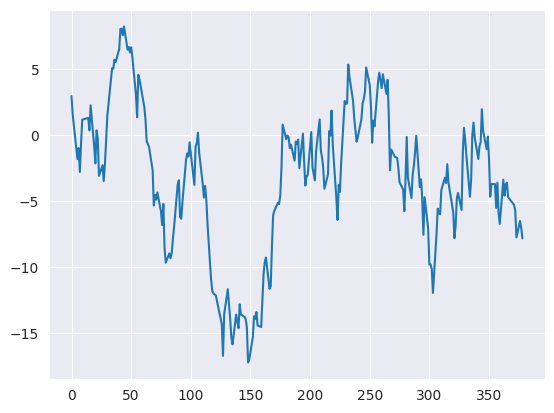

In [47]:
forecast_naives["residual"] = forecast_naives["y"] - forecast_naives["SeasonalNaive"]
forecast_naives["residual"].plot()
plt.show()

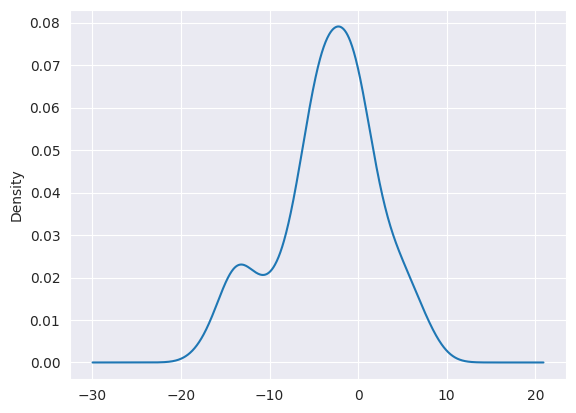

count    259.000000
mean      -3.383865
std        5.544601
min      -17.246996
25%       -5.977497
50%       -2.989002
75%       -0.038501
max        8.202004
Name: residual, dtype: float64


In [48]:
forecast_naives["residual"].plot(kind='kde')
plt.show()
print(forecast_naives["residual"].describe())

### Modelo com Arima

    WMape Arima: 5.68%
    MSE Arima: 6082.34%
    MAE Arima: 622.78%
    RMSE Arima: 779.89%

In [72]:
periodo_base = int(len(dados_modelo) * 0.2) # determinando o período
train, test = dados_modelo.iloc[:-periodo_base], dados_modelo.iloc[-periodo_base:]
h = len(test)

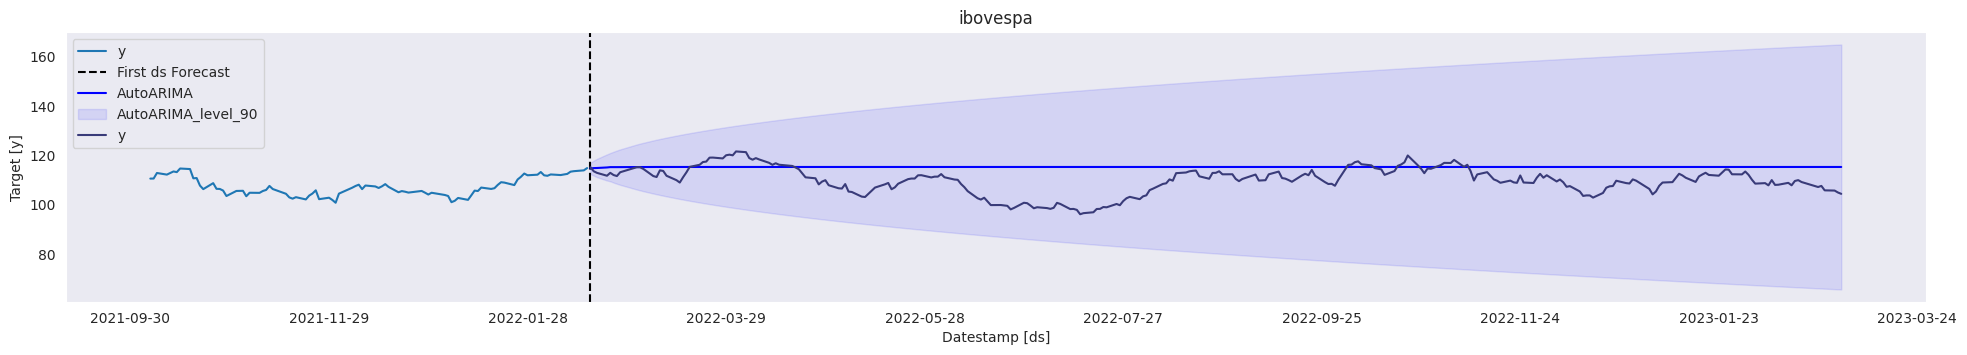

In [50]:
model_arima = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_arima.fit(train)

forecast_arima = model_arima.predict(h=h, level=[90])
forecast_arima = forecast_arima.reset_index().merge(test, on=['ds', 'unique_id'], how='left').dropna()
model_arima.plot(train, forecast_arima, level=[90], unique_ids=["ibovespa"], max_insample_length=90)

In [51]:
# Avaliação de resultados Naive com Walk Foward
wmape_arima = wmape(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values)
print(f'WMape Arima: {wmape_arima:.2%}')

mse_arima = mean_squared_error(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values)
print(f'MSE Arima: {mse_arima:.2%}')

mae_arima = mean_absolute_error(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values)
print(f'MAE Arima: {mae_arima:.2%}')

rmse_arima = math.sqrt(mean_squared_error(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values))
print(f'RMSE Arima: {rmse_arima:.2%}')

WMape Arima: 5.68%
MSE Arima: 6082.34%
MAE Arima: 622.78%
RMSE Arima: 779.89%


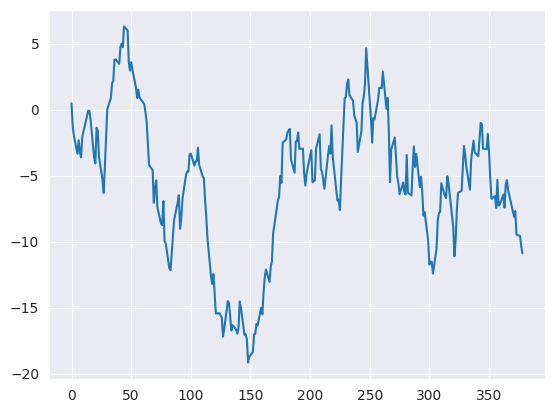

In [52]:
forecast_arima["residual"] = forecast_arima["y"] - forecast_arima["AutoARIMA"]
forecast_arima["residual"].plot()
plt.show()

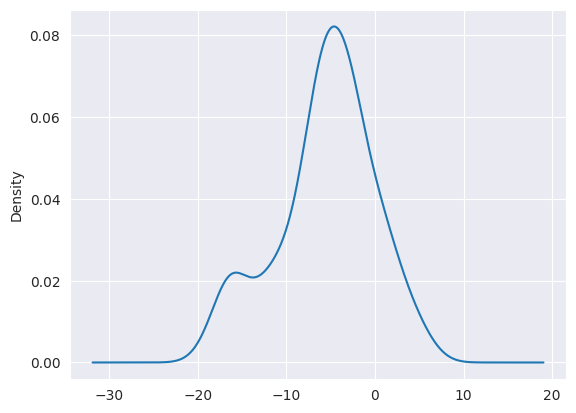

count    259.000000
mean      -5.560617
std        5.478949
min      -19.153033
25%       -8.224533
50%       -5.038033
75%       -2.094228
max        6.295975
Name: residual, dtype: float64


In [53]:
forecast_arima["residual"].plot(kind='kde')
plt.show()
print(forecast_arima["residual"].describe())

### Modelo com prophet V1

      WMape prophet: 2.67%
      MSE prophet: 954.99%
      MAE prophet: 308.32%
      RMSE prophet: 175.59%

In [80]:
# periodo_base = int(len(dados_modelo) * 0.2) # determinando o período
periodo_base = 5 # determinando o período
train, test = dados_modelo.iloc[:-periodo_base], dados_modelo.iloc[-periodo_base:]
h = len(test)

In [97]:
#fit do modelo
model = Prophet()
model.fit(train)

#predições
future = model.make_future_dataframe(periods=(len(test)+3), freq='d')
validation_week = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[validation_week]
forecast = model.predict(future)
forecast_valid = forecast['yhat'][-periodo_base:]

test['yhat'] = 0
test['yhat'] = forecast_valid.values

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rq86q_q/lobg4k9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rq86q_q/1ejq47rm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28919', 'data', 'file=/tmp/tmp4rq86q_q/lobg4k9y.json', 'init=/tmp/tmp4rq86q_q/1ejq47rm.json', 'output', 'file=/tmp/tmp4rq86q_q/prophet_model_4n4pvkl/prophet_model-20230902233439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:34:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-97-4c8e17c14c42>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

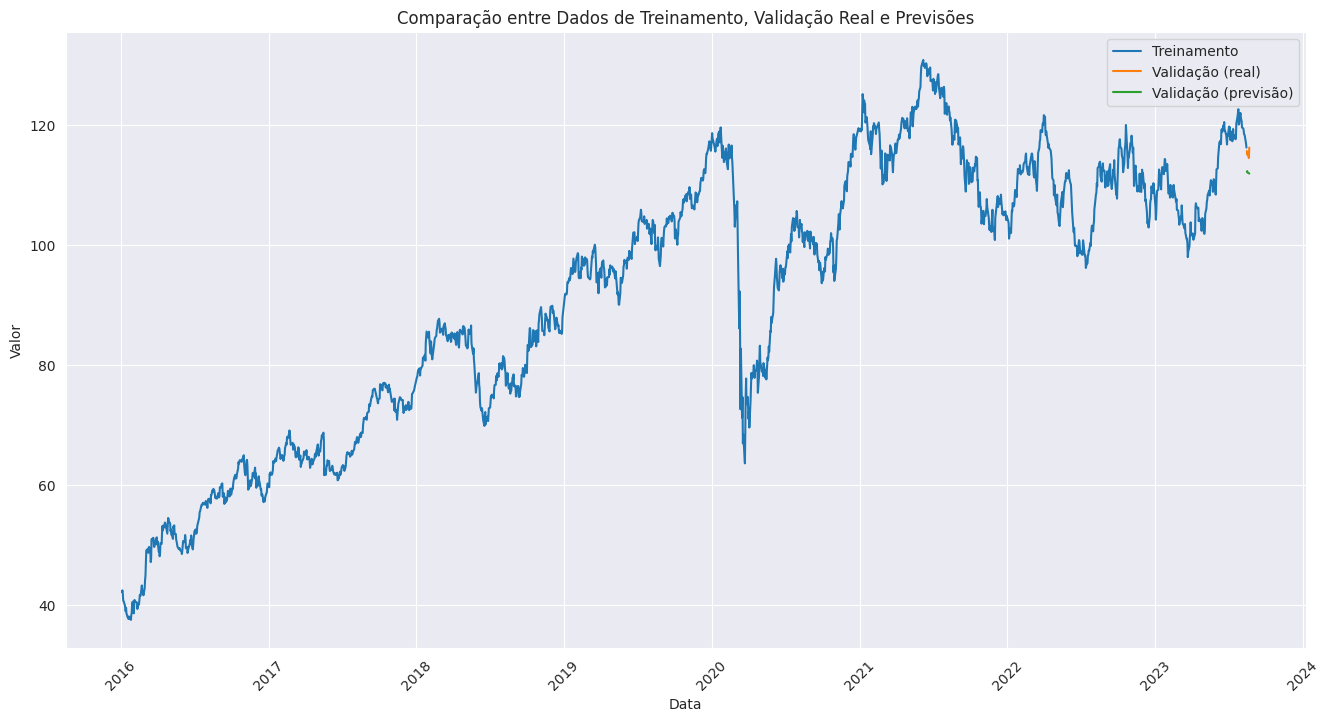

In [98]:
plt.figure(figsize=(16, 8))
plt.plot(train['ds'], train['y'], label='Treinamento')  # Usando "ds" no eixo x para o treinamento
plt.plot(test['ds'], test['y'], label='Validação (real)')  # Usando "ds" no eixo x para a validação real
plt.plot(test['ds'], test['yhat'], label='Validação (previsão)')  # Usando "ds" no eixo x para as previsões
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhorar a legibilidade
plt.xlabel('Data')  # Adiciona rótulo ao eixo x
plt.ylabel('Valor')  # Adiciona rótulo ao eixo y
plt.title('Comparação entre Dados de Treinamento, Validação Real e Previsões')
plt.show()

In [99]:
plot_plotly(model,forecast)

In [100]:
fig = go.Figure([
    go.Scatter(x=dados_modelo['ds'], y=dados_modelo['y'], name='Actual', mode='lines'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted', mode='lines'),
    go.Scatter(x=test['ds'], y=test['y'], name='Real', mode='lines')
])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=2, label="2d", step="day", stepmode="backward"), dict(count=1, label="1m", step="month", stepmode="backward"),dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"), dict(count=1, label="1y", step="year", stepmode="backward"), dict(step="all")])))
fig.show()

In [86]:
# Avaliação das previsões
validacao_prophet = forecast.set_index('ds')[['yhat']].join(test.set_index('ds').y).reset_index().dropna()

wmape_prophet = wmape(validacao_prophet['y'].values, validacao_prophet['yhat'].values)
print(f'WMape prophet: {wmape_prophet:.2%}')

mse_prophet = mean_squared_error(validacao_prophet['y'].values, validacao_prophet['yhat'].values)
print(f'MSE prophet: {mse_prophet:.2%}')

mae_prophet = mean_absolute_error(validacao_prophet['y'].values, validacao_prophet['yhat'].values)
print(f'MAE prophet: {mae_prophet:.2%}')

rmse_prophet = math.sqrt(mean_absolute_error(validacao_prophet['y'].values, validacao_prophet['yhat'].values))
print(f'RMSE prophet: {rmse_prophet:.2%}')

WMape prophet: 2.67%
MSE prophet: 954.99%
MAE prophet: 308.32%
RMSE prophet: 175.59%


### Modelo com prophet V2 - Ajustando parametros

    WMape prophet V2: 2.67%
    MSE prophet V2: 954.99%
    MAE prophet V2: 308.32%
    RMSE prophet V2: 175.59%

In [107]:
# periodo_base = int(len(dados_modelo) * 0.2) # determinando o período
periodo_base = 5 # determinando o período
train, test = dados_modelo.iloc[:-periodo_base], dados_modelo.iloc[-periodo_base:]
h = len(test)

In [ ]:
#fit do modelo
model = Prophet(seasonality_mode="multiplicative", growth="linear") # ajuste de hiperametros
model.fit(train)

#predições
future = model.make_future_dataframe(periods=(len(test)+3), freq='d')
validation_week = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[validation_week]
forecast = model.predict(future)
forecast_valid = forecast['yhat'][-periodo_base:]

test['yhat'] = 0
test['yhat'] = forecast_valid.values

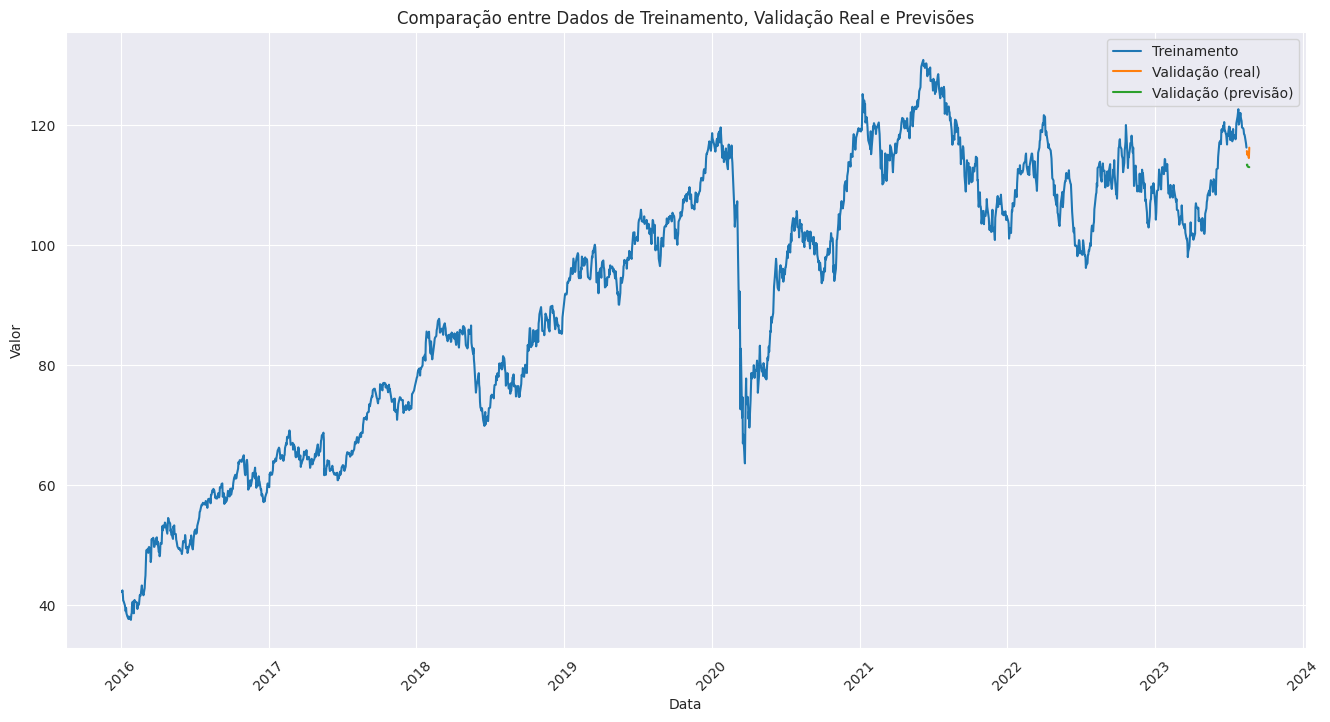

In [109]:
plt.figure(figsize=(16, 8))
plt.plot(train['ds'], train['y'], label='Treinamento')  # Usando "ds" no eixo x para o treinamento
plt.plot(test['ds'], test['y'], label='Validação (real)')  # Usando "ds" no eixo x para a validação real
plt.plot(test['ds'], test['yhat'], label='Validação (previsão)')  # Usando "ds" no eixo x para as previsões
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhorar a legibilidade
plt.xlabel('Data')  # Adiciona rótulo ao eixo x
plt.ylabel('Valor')  # Adiciona rótulo ao eixo y
plt.title('Comparação entre Dados de Treinamento, Validação Real e Previsões')
plt.show()

In [110]:
plot_plotly(model,forecast)

In [111]:
fig = go.Figure([
    go.Scatter(x=dados_modelo['ds'], y=dados_modelo['y'], name='Actual', mode='lines'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted', mode='lines'),
    go.Scatter(x=test['ds'], y=test['y'], name='Real', mode='lines')
])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=2, label="2d", step="day", stepmode="backward"), dict(count=1, label="1m", step="month", stepmode="backward"),dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"), dict(count=1, label="1y", step="year", stepmode="backward"), dict(step="all")])))
fig.show()

In [112]:
# Avaliação das previsões
validacao_prophet_v2 = forecast.set_index('ds')[['yhat']].join(test.set_index('ds').y).reset_index().dropna()

wmape_prophet_v2 = wmape(validacao_prophet['y'].values, validacao_prophet['yhat'].values)
print(f'WMape prophet V2: {wmape_prophet_v2:.2%}')

mse_prophet_v2 = mean_squared_error(validacao_prophet['y'].values, validacao_prophet['yhat'].values)
print(f'MSE prophet V2: {mse_prophet_v2:.2%}')

mae_prophet_v2 = mean_absolute_error(validacao_prophet['y'].values, validacao_prophet['yhat'].values)
print(f'MAE prophet V2: {mae_prophet_v2:.2%}')

rmse_prophet_v2 = math.sqrt(mean_absolute_error(validacao_prophet['y'].values, validacao_prophet['yhat'].values))
print(f'RMSE prophet V2: {rmse_prophet_v2:.2%}')

WMape prophet V2: 2.67%
MSE prophet V2: 954.99%
MAE prophet V2: 308.32%
RMSE prophet V2: 175.59%


### Modelo com prophet 3 - 2022 a 2023

    WMape prophet: 7.62%
    MSE prophet: 7762.64%
    MAE prophet: 878.87%
    RMSE prophet: 296.46%

In [114]:
dados_modelo

,ds,y,unique_id
0,2016-01-04,42.141,ibovespa
1,2016-01-05,42.419,ibovespa
2,2016-01-06,41.773,ibovespa
3,2016-01-07,40.695,ibovespa
4,2016-01-08,40.612,ibovespa
...,...,...,...
1890,2023-08-16,115.592,ibovespa
1891,2023-08-17,114.982,ibovespa
1892,2023-08-18,115.409,ibovespa
1893,2023-08-21,114.429,ibovespa


In [117]:
# periodo_base = int(len(dados_modelo) * 0.2) # determinando o período
dados_modelo_novo = dados_modelo.loc[dados_modelo["ds"] > "2021-12-31"	]
periodo_base = 5 # determinando o período
train, test = dados_modelo_novo.iloc[:-periodo_base], dados_modelo_novo.iloc[-periodo_base:]
h = len(test)

In [118]:
#fit do modelo
model = Prophet(seasonality_mode="multiplicative", growth="linear") # ajuste de hiperametros)
model.fit(train)

#predições
future = model.make_future_dataframe(periods=(len(test)+3), freq='d')
validation_week = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[validation_week]
forecast = model.predict(future)
forecast_valid = forecast['yhat'][-periodo_base:]

test['yhat'] = 0
test['yhat'] = forecast_valid.values

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rq86q_q/dliqmnmx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rq86q_q/_dvlyvs7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29181', 'data', 'file=/tmp/tmp4rq86q_q/dliqmnmx.json', 'init=/tmp/tmp4rq86q_q/_dvlyvs7.json', 'output', 'file=/tmp/tmp4rq86q_q/prophet_modelpotgiqy5/prophet_model-20230902234337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:43:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:43:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-118-b497953841b0>:12: Set

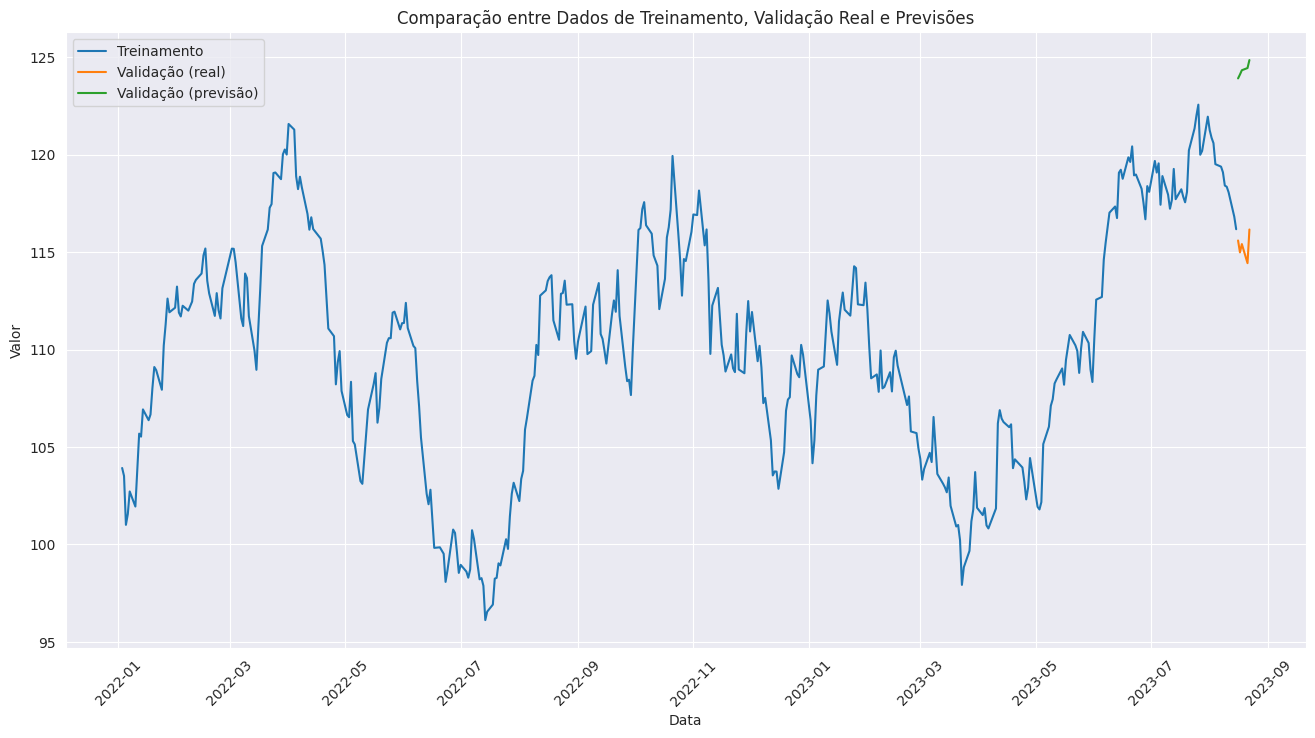

In [119]:
plt.figure(figsize=(16, 8))
plt.plot(train['ds'], train['y'], label='Treinamento')  # Usando "ds" no eixo x para o treinamento
plt.plot(test['ds'], test['y'], label='Validação (real)')  # Usando "ds" no eixo x para a validação real
plt.plot(test['ds'], test['yhat'], label='Validação (previsão)')  # Usando "ds" no eixo x para as previsões
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhorar a legibilidade
plt.xlabel('Data')  # Adiciona rótulo ao eixo x
plt.ylabel('Valor')  # Adiciona rótulo ao eixo y
plt.title('Comparação entre Dados de Treinamento, Validação Real e Previsões')
plt.show()

In [120]:
plot_plotly(model,forecast)

In [122]:
fig = go.Figure([
    go.Scatter(x=dados_modelo_novo['ds'], y=dados_modelo_novo['y'], name='Actual', mode='lines'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted', mode='lines'),
    go.Scatter(x=test['ds'], y=test['y'], name='Real', mode='lines')
])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=2, label="2d", step="day", stepmode="backward"), dict(count=1, label="1m", step="month", stepmode="backward"),dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"), dict(count=1, label="1y", step="year", stepmode="backward"), dict(step="all")])))
fig.show()

In [123]:
# Avaliação das previsões
validacao_prophet = forecast.set_index('ds')[['yhat']].join(test.set_index('ds').y).reset_index().dropna()

wmape_prophet = wmape(validacao_prophet['y'].values, validacao_prophet['yhat'].values)
print(f'WMape prophet: {wmape_prophet:.2%}')

mse_prophet = mean_squared_error(validacao_prophet['y'].values, validacao_prophet['yhat'].values)
print(f'MSE prophet: {mse_prophet:.2%}')

mae_prophet = mean_absolute_error(validacao_prophet['y'].values, validacao_prophet['yhat'].values)
print(f'MAE prophet: {mae_prophet:.2%}')

rmse_prophet = math.sqrt(mean_absolute_error(validacao_prophet['y'].values, validacao_prophet['yhat'].values))
print(f'RMSE prophet: {rmse_prophet:.2%}')

WMape prophet: 7.62%
MSE prophet: 7762.64%
MAE prophet: 878.87%
RMSE prophet: 296.46%


### Avaliação até então.

Nos dois modelos acima, tivemos baixos valores de WMAPE, porém valores altos de erros absolutos entre os erros. O ideal são valores mais próximos de


RMSE: desvio padrão da amostra da diferença entre o previsto e o valor real. É dependente da unidade em que usamos, então facilita a interpretação.

# OUTROS MATERIAIS

### 📊 Análise 1: Relatório com métricas de performance

In [ ]:
uniao_dados = forecast.set_index('ds')[['yhat']].join(dados_modelo.set_index('ds').y).reset_index().dropna()

wmape_forecast_v1 = wmape(uniao_dados['y'].values, uniao_dados['yhat'].values)
print(f'WMape V1: {wmape_forecast_v1:.2%}')

mse_forecast_v1 = mean_squared_error(uniao_dados['y'].values, uniao_dados['yhat'].values)
print(f'MSE V1: {mse_forecast_v1:.2%}')

mae_forecast_v1 = mean_absolute_error(uniao_dados['y'].values, uniao_dados['yhat'].values)
print(f'MAE V1: {mae_forecast_v1:.2%}')

rmse_forecast_v1 = math.sqrt(mean_absolute_error(uniao_dados['y'].values, uniao_dados['yhat'].values))
print(f'RMSE V1: {rmse_forecast_v1:.2%}')

WMape V1: 2.44%
MSE V1: 1042.19%
MAE V1: 268.87%
RMSE V1: 163.97%


**Inferências Modelo 1:**

> Apesar do WMape relativamente baixo, as outras margens de erro MSE, MAE e RMSE indicam uma grande dispersão entre os dados previstos e os reais.

#### Validação Cruzada

In [ ]:
# execute cross validation
df_cv = cross_validation(model, initial='421 days', period='7 days', horizon = '30 days')

# measure performance
df_p = performance_metrics(df_cv)

INFO:prophet:Making 21 forecasts with cutoffs between 2023-03-05 00:00:00 and 2023-07-23 00:00:00


  0%|          | 0/21 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmprg8u41ju/id6bmsz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprg8u41ju/7ox4nuhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10875', 'data', 'file=/tmp/tmprg8u41ju/id6bmsz5.json', 'init=/tmp/tmprg8u41ju/7ox4nuhh.json', 'output', 'file=/tmp/tmprg8u41ju/prophet_model6ho2jy3i/prophet_model-20230902153805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:38:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmprg8u41ju/p3e_rrf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprg8u41ju/5nxpunij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
print(df_cv.tail()) # visualize data
print(df_p) # measure performance

            ds        yhat  yhat_lower  yhat_upper           y     cutoff
440 2023-08-16  124.159069  120.284446  127.786265  116.233749 2023-07-23
441 2023-08-17  124.423795  120.865432  128.134597  115.607875 2023-07-23
442 2023-08-18  124.665385  121.030361  128.658471  115.508437 2023-07-23
443 2023-08-21  125.013289  121.397040  129.021583  114.968719 2023-07-23
444 2023-08-22  125.095749  121.258865  129.039445  115.562359 2023-07-23
   horizon        mse      rmse       mae      mape     mdape     smape  \
0   3 days  24.951390  4.995137  4.125933  0.037300  0.034808  0.038052   
1   4 days  25.318306  5.031730  4.079610  0.036886  0.033944  0.037623   
2   5 days  28.748526  5.361765  4.364276  0.039412  0.036461  0.040239   
3   8 days  34.157116  5.844409  4.801418  0.043287  0.036265  0.044304   
4   9 days  36.311112  6.025870  4.914852  0.044289  0.041481  0.045411   
5  10 days  37.228062  6.101480  4.932069  0.044361  0.043336  0.045528   
6  11 days  37.401128  6.115646

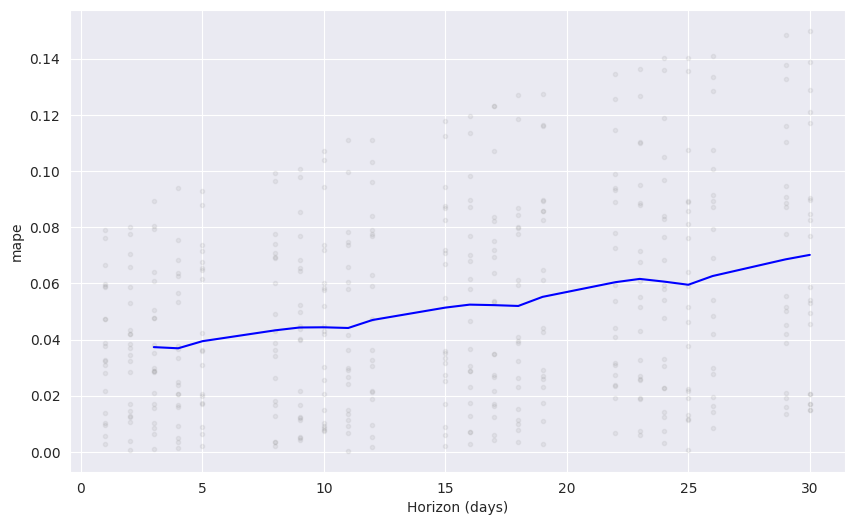

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')